# Anomaly Detection

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('/Users/josuealemansanchez/Desktop/eco-tools')
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')
from data_helper import *
import warnings
warnings.filterwarnings('ignore')

## Get Data

In [2]:
#search for point if needed
point = pc.search_by_point('*gbsf*elec*demand*kbtu*')
point

['GBSF_Electricity_Demand_kBtu']

### Set Data Parameters

In [3]:
start = '2016-01-01'
end = '*'
interval = '1h'
calculation = 'summary'

### Ensure only one point is passed

Grabbing WebIDs ...
WebID collection complete!
16:08:48: Sending API request... Chunk 1 of 1
16:08:49: Response recieved for 1 tags! (1.52)


Column                      |Percent NaN | Rows NaN/Total Rows
--------------------------------------------------------------
GBSF_Electricity_Demand_kBtu|  0.07 %    | 23/31548


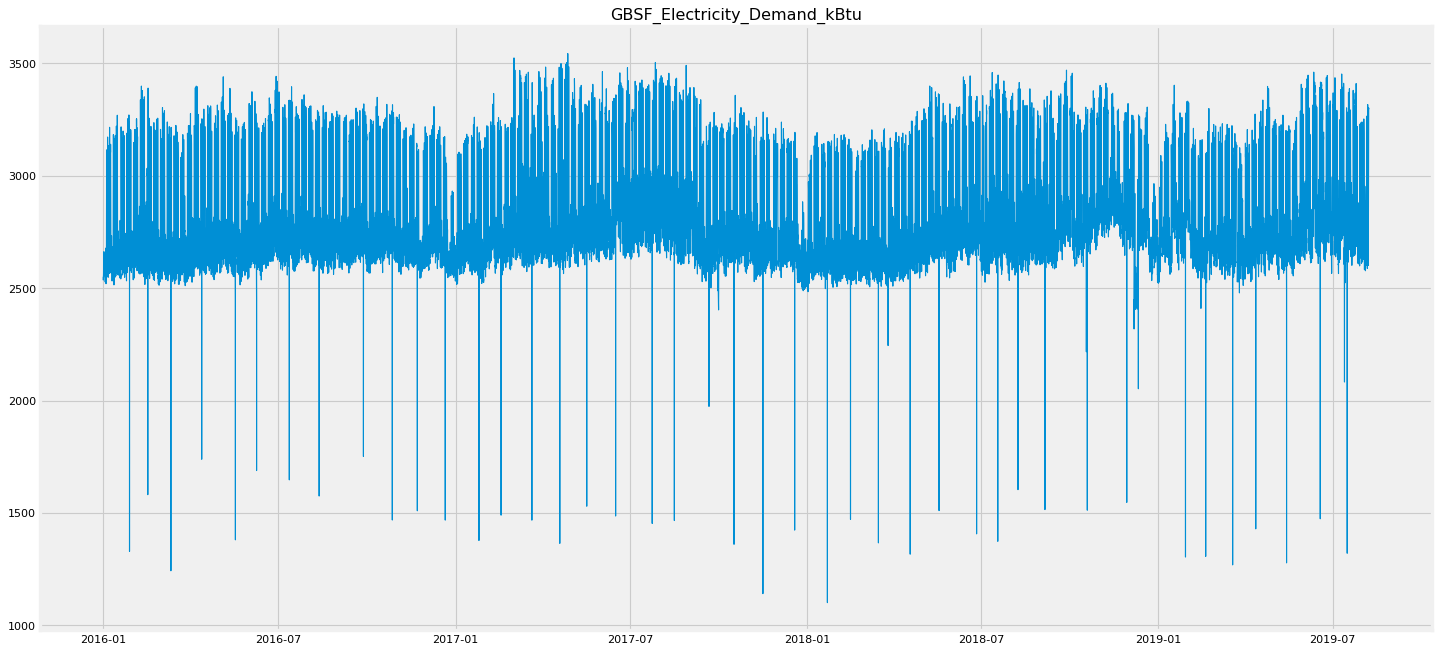

In [4]:
df = pc.get_stream_by_point(point, start = start, end = end, interval = interval, calculation = calculation)
print_report(df)

In [5]:
df.index[-1]#.strftime('%Y-%m-%d')

Timestamp('2019-08-07 15:00:00')

## Generate Model

In [6]:
kwargs = {
    #the point to be evaluated
    'point': point[0],
    
    #can be either 'LSTM' or 'Random Forest'
    'model_type': 'LSTM',
################################### Data Pre-processing ################################    
    #Determining the amount of data that will be used to train the model 0 < training_percent < 1.0
    'training_percent': 0.7,
    
    #determine if use wants the data to be cleaned 
    'clean_data': True,
    #clean_type can be either 'value' (any points below the value passed will be cut out) or 'iqr'
    'clean_type': 'iqr',

    #if clean is 'value' then pass the value you want the cut to be
    # if you want IQR then determine the IQR to cut at
    'threshold': 2.500,
    
    #Show plot with cutoff(s)
    'show_cutoff_plot': True,
    
    #show plot with training and testing data
    'show_cleaned_plot': True,
    
    #determine what method to use 'bfill' (back fill) or 'ffill' (foward fill) data 
    'method': 'bfill',
##############################################################    
    
    #determine if model should train on residuals or the normal data
    'train_on_residuals': True,
    
    'show_training_plot' : True,
    
    'show_results_plots' : True 

}

In [7]:
check_kwargs(kwargs)

'Good values!'

lower_bound: 1675.131360 and upper_bound: 3999.875503


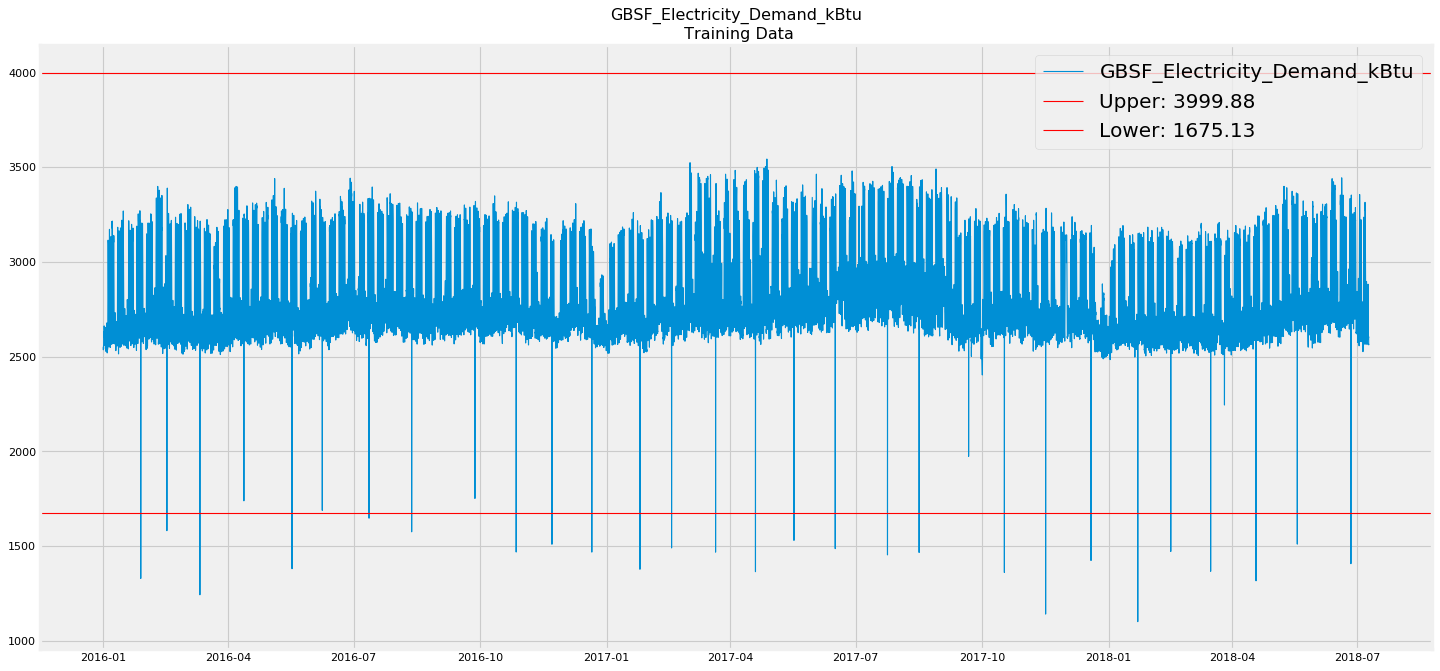

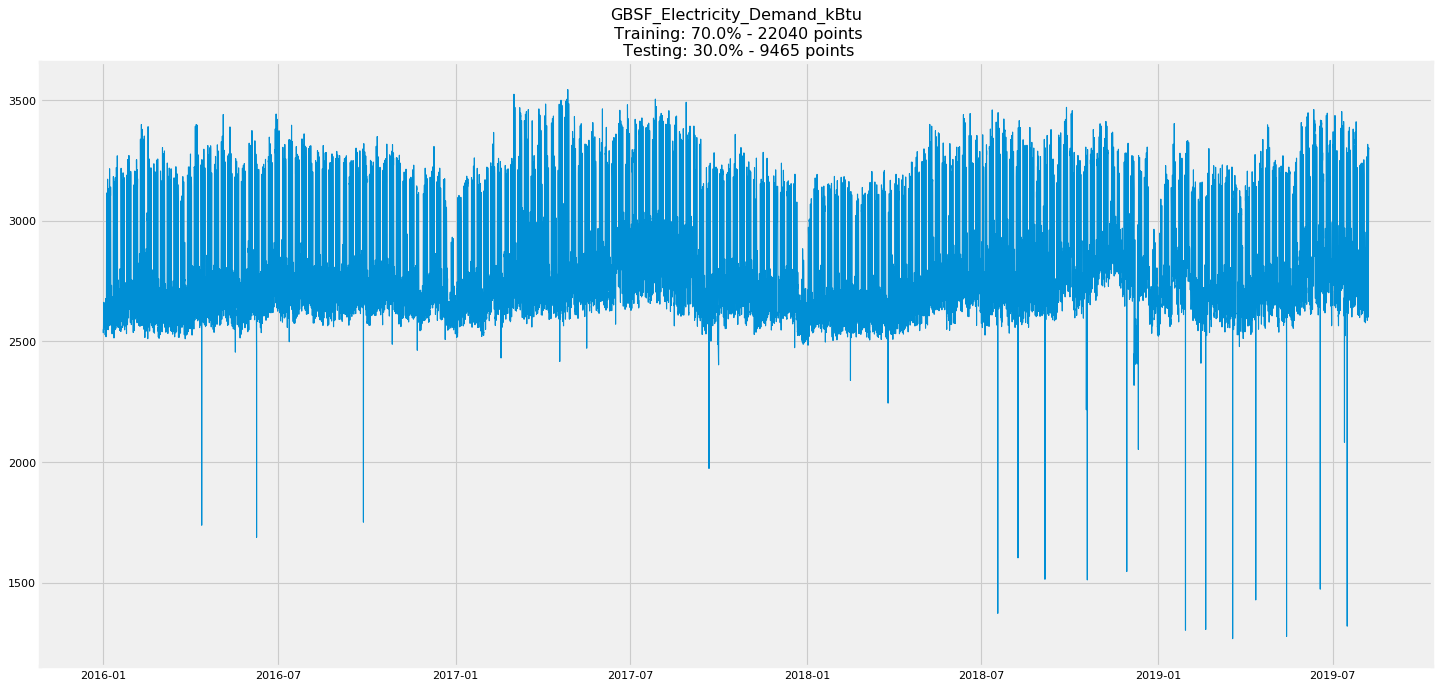

In [8]:
df1 = split_and_clean(df, kwargs)

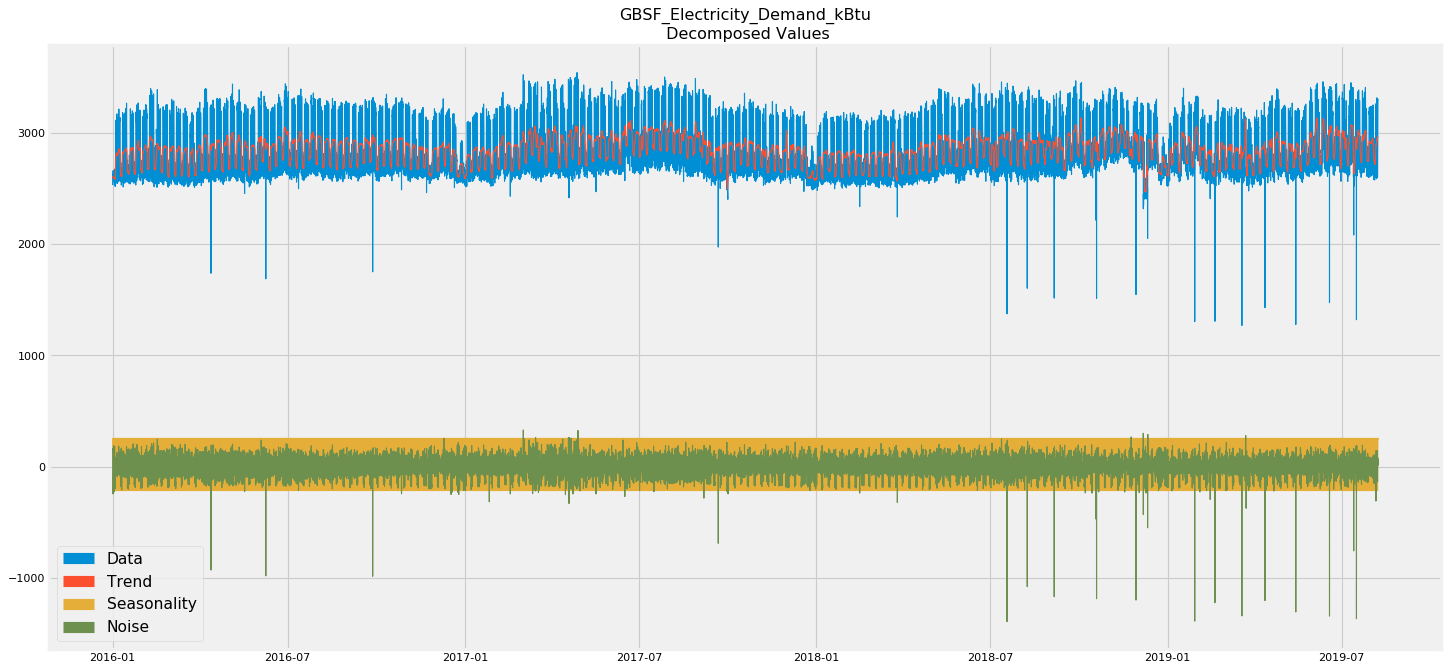

In [9]:
plot_decomposed_data(df1[point[0]], kwargs)

Using TensorFlow backend.


Grabbing WebIDs ...
WebID collection complete!
16:08:55: Sending API request... Chunk 1 of 1
16:08:58: Response recieved for 3 tags! (3.27)
Removed: 0 rows


W0807 16:08:59.198378 4627789248 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 16:08:59.211663 4627789248 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 16:08:59.213865 4627789248 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 16:08:59.519388 4627789248 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimiz

Train on 15459 samples, validate on 6626 samples
Epoch 1/10
15459/15459 [==============================] - 3s 206us/step - loss: 0.0280 - val_loss: 0.0016
Epoch 2/10
15459/15459 [==============================] - 2s 141us/step - loss: 9.7241e-04 - val_loss: 0.0018
Epoch 3/10
15459/15459 [==============================] - 2s 144us/step - loss: 7.5335e-04 - val_loss: 0.0012
Epoch 4/10
15459/15459 [==============================] - 2s 146us/step - loss: 6.9872e-04 - val_loss: 6.3016e-04
Epoch 5/10
15459/15459 [==============================] - 2s 144us/step - loss: 6.5185e-04 - val_loss: 5.4673e-04
Epoch 6/10
15459/15459 [==============================] - 2s 141us/step - loss: 6.5265e-04 - val_loss: 0.0021
Epoch 7/10
15459/15459 [==============================] - 2s 142us/step - loss: 6.4180e-04 - val_loss: 0.0023
Epoch 8/10
15459/15459 [==============================] - 2s 144us/step - loss: 7.1647e-04 - val_loss: 0.0031
Epoch 9/10
15459/15459 [==============================] - 2s 147us/

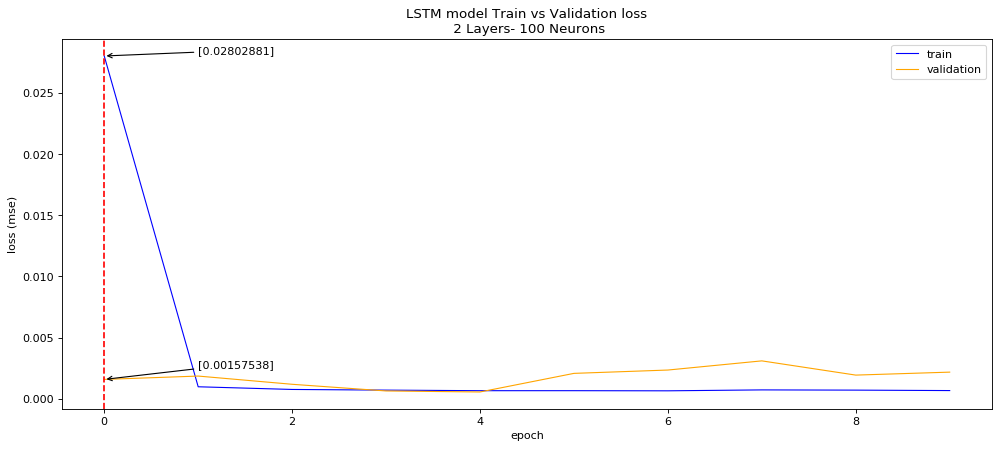

In [10]:
from model_generator import *
model,X_train, X_test, y_train, y_test, scaler , train_idx, test_idx = create_model(df1, kwargs)

<Figure size 2000x1000 with 0 Axes>

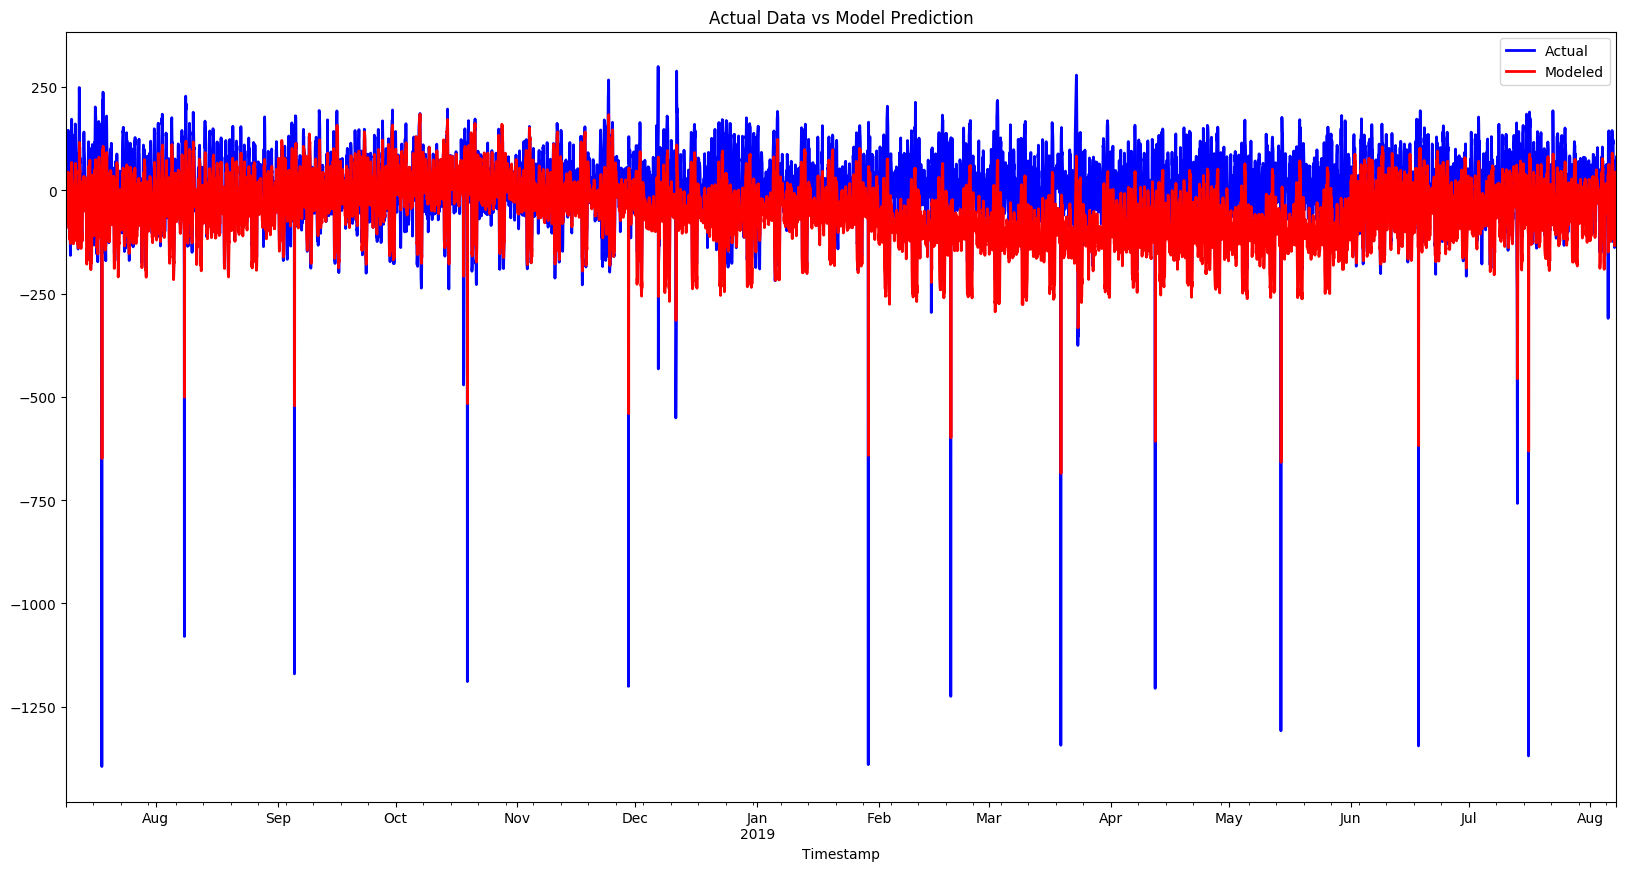

In [15]:
prediction = model.predict(X_test)
prediction = scaler.inverse_transform(prediction.reshape(-1,1))
plt.figure(figsize=(20,10))
result = pd.DataFrame({"Actual":scaler.inverse_transform(y_test).reshape((-1,)),
                                   "Modeled":prediction.reshape((-1,))}, index=test_idx)

result.plot(figsize=(20,10),
                         title="Actual Data vs Model Prediction",
                         linewidth=2,
                         color=['blue','red'])

<Figure size 2000x1000 with 0 Axes>

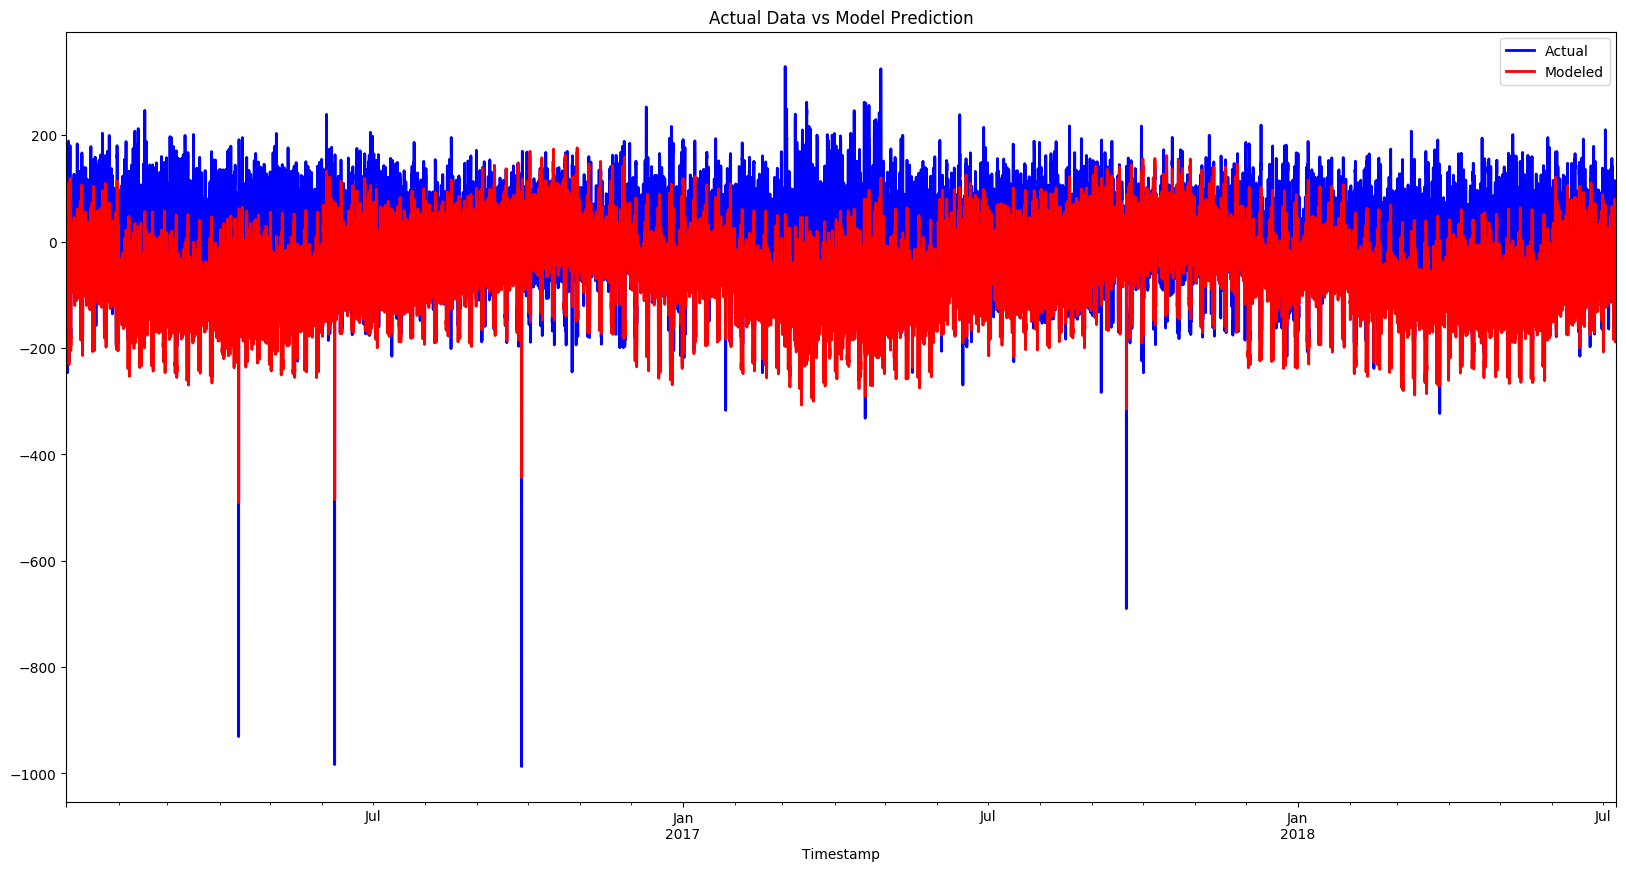

In [19]:
prediction1 = model.predict(X_train)
prediction1 = scaler.inverse_transform(prediction1.reshape(-1,1))
plt.figure(figsize=(20,10))
result1 = pd.DataFrame({"Actual":scaler.inverse_transform(y_train).reshape((-1,)),
                                   "Modeled":prediction1.reshape((-1,))}, index=train_idx)

result1.plot(figsize=(20,10),
                         title="Actual Data vs Model Prediction",
                         linewidth=2,
                         color=['blue','red'])

In [23]:
result1.head()

,Actual,Modeled
Timestamp,,
2016-01-01 01:00:00,129.498793,15.951237
2016-01-01 02:00:00,138.814734,11.672945
2016-01-01 03:00:00,154.586736,11.841344
2016-01-01 04:00:00,163.519853,20.362581
2016-01-01 05:00:00,149.893849,32.339848
